# Text classification with Unsloth

This modified Unsloth notebook trains an LLM on any text classification dataset, where the input is a csv with columns "text" and "label".

### Added features:

- Trims the classification head to contain only the number tokens such as "1", "2" etc, which saves 1 GB of VRAM, allows you to train the head without massive memory usage, and makes the start of the training session more stable.
- Only the last token in the sequence contributes to the loss, the model doesn't waste its capacity by trying to predict the input
- includes "group_by_length = True" which speeds up training significantly for unbalanced sequence lengths
- Efficiently evaluates the accuracy on the validation set using batched inference

### Update 4th of May 2025:

- Added support for more than 2 classes
- The classification head is now built back up to the original size after training, no more errors in external libraries.
- Made the batched inference part much faster and cleaner
- Changed model to Qwen 3
- Improved comments to explain the complicated parts

In [1]:
# needed as this function doesn't like it when the lm_head has its size changed
from unsloth import tokenizer_utils
def do_nothing(*args, **kwargs):
    pass
tokenizer_utils.fix_untrained_tokens = do_nothing

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
import torch
major_version, minor_version = torch.cuda.get_device_capability()
print(f"Major: {major_version}, Minor: {minor_version}")
from datasets import load_dataset
import datasets
from trl import SFTTrainer
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments, Trainer
from typing import Tuple
import warnings
from typing import Any, Dict, List, Union
from transformers import DataCollatorForLanguageModeling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

NUM_CLASSES = 3 # number of classes in the csv

max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+

# model_name = "unsloth/Qwen3-4B-Base";load_in_4bit = False
model_name = "Qwen3-4B-Base";load_in_4bit = False

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,load_in_4bit = load_in_4bit,
    max_seq_length = max_seq_length,
    dtype = dtype,
)

Major: 8, Minor: 6


c:\ProgramData\Anaconda3\Lib\site-packages\unsloth_zoo\gradient_checkpointing.py:330: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  GPU_BUFFERS = tuple([torch.empty(2*256*2048, dtype = dtype, device = f"cuda:{i}") for i in range(n_gpus)])


==((====))==  Unsloth 2025.4.5: Fast Qwen3 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.999 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.6. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

We now trim the classification head so the model can only say numbers 0-NUM_CLASSES and no other words. (We don't use 0 here but keeping it makes everything simpler)

In [3]:
number_token_ids = []
for i in range(0, NUM_CLASSES+1):
    number_token_ids.append(tokenizer.encode(str(i), add_special_tokens=False)[0])
# keep only the number tokens from lm_head
par = torch.nn.Parameter(model.lm_head.weight[number_token_ids, :])

old_shape = model.lm_head.weight.shape
old_size = old_shape[0]
print(par.shape)
print(old_shape)

model.lm_head.weight = par

reverse_map = {value: idx for idx, value in enumerate(number_token_ids)} # will be used later to convert an idx from the old tokenizer to the new lm_head
reverse_map

torch.Size([4, 2560])
torch.Size([151936, 2560])


{15: 0, 16: 1, 17: 2, 18: 3}

In [4]:
from peft import LoftQConfig

model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = [
        "lm_head", # can easily be trained because it now has a small size
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = True,  # We support rank stabilized LoRA
    # init_lora_weights = 'loftq',
    # loftq_config = LoftQConfig(loftq_bits = 4, loftq_iter = 1), # And LoftQ
)
print("trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Unsloth: Offloading output_embeddings to disk to save VRAM


Unsloth 2025.4.5 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


Unsloth: Training lm_head in mixed precision to save VRAM
trainable parameters: 33040384


In [5]:
kaggle = os.getcwd() == "/kaggle/working"
input_dir = "/kaggle/input/whatever/" if kaggle else "data/"
data = pd.read_csv(input_dir + "finance_sentiment_multiclass.csv") # columns are text,label

train_size = 4000
val_size = 320

data_sample = data.sample(n=train_size+val_size, random_state=42)
train_df, val_df = train_test_split(data_sample, test_size=val_size/len(data_sample), random_state=42)
train_dataset = datasets.Dataset.from_pandas(train_df,preserve_index=False)
print(len(train_df))

4000


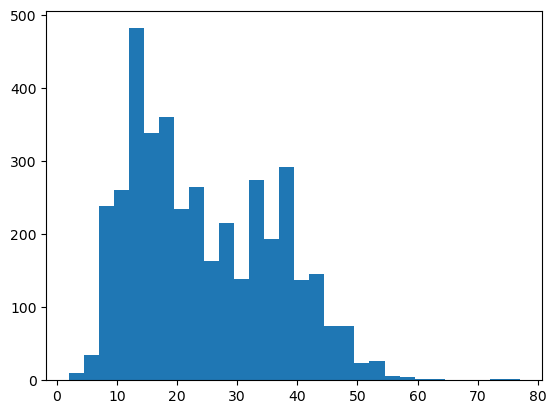

In [6]:
token_counts = [len(tokenizer.encode(x)) for x in train_df.text]
# plot the token counts
a = plt.hist(token_counts, bins=30)

In [7]:
prompt = """Here is a financial news:
{}

Classify this news into one of the following:
class 1: Bullish
class 2: Neutral
class 3: Bearish

SOLUTION
The correct answer is: class {}"""

def formatting_prompts_func(dataset_):
    # this is to fix an issue with the transformers library where the first time this function is called, it is called with a string for some reason
    if isinstance(dataset_['text'], str):
        return [" "]*100
        
    texts = []
    for i in range(len(dataset_['text'])):
        text_ = dataset_['text'][i]
        label_ = dataset_['label'][i] # the csv is setup so that the label column corresponds exactly to the 3 classes defined above in the prompt (important)

        text = prompt.format(text_, label_)

        texts.append(text)
    return texts

In [8]:
# this custom collator makes it so the model trains only on the last token of the sequence. It also maps from the old tokenizer to the new lm_head indices
class DataCollatorForLastTokenLM(DataCollatorForLanguageModeling):
    def __init__(
        self,
        *args,
        mlm: bool = False,
        ignore_index: int = -100,
        **kwargs,
    ):
        super().__init__(*args, mlm=mlm, **kwargs)
        self.ignore_index = ignore_index

    def torch_call(self, examples: List[Union[List[int], Any, Dict[str, Any]]]) -> Dict[str, Any]:
        batch = super().torch_call(examples)

        for i in range(len(examples)):
            # Find the last non-padding token
            last_token_idx = (batch["labels"][i] != self.ignore_index).nonzero()[-1].item()
            # Set all labels to ignore_index except for the last token
            batch["labels"][i, :last_token_idx] = self.ignore_index
            # If the last token in the text is, for example, "2", then this was processed with the old tokenizer into number_token_ids[2]
            # But we don't actually want this because number_token_ids[2] could be something like 27, which is now undefined in the new lm_head. So we map it to the new lm_head index.
            batch["labels"][i, last_token_idx] = reverse_map[ batch["labels"][i, last_token_idx].item() ]


        return batch
collator = DataCollatorForLastTokenLM(tokenizer=tokenizer)

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [9]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    max_seq_length = max_seq_length,
    dataset_num_proc = 1,
    packing = False, # not needed because group_by_length is True
    args = TrainingArguments(
        per_device_train_batch_size = 32,
        gradient_accumulation_steps = 1,
        warmup_steps = 10,
        learning_rate = 1e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        num_train_epochs = 1,
        # report_to = "wandb",
        report_to = "none",
        group_by_length = True,
    ),
    formatting_func=formatting_prompts_func,
    data_collator=collator,
)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [10]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 3090. Max memory = 23.999 GB.
8.41 GB of memory reserved.


In [11]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,000 | Num Epochs = 1 | Total steps = 125
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 1 x 1) = 32
 "-____-"     Trainable parameters = 33,040,384/4,055,518,720 (0.81% trained)


Step,Training Loss
1,1.684900
2,1.167400
3,1.191000
4,1.096000
5,1.093100
6,0.924200
7,0.847800
8,0.926600
9,0.848900
10,0.840200


Unsloth: Will smartly offload gradients to save VRAM!


In [12]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

341.2138 seconds used for training.
5.69 minutes used for training.
Peak reserved memory = 9.082 GB.
Peak reserved memory for training = 0.672 GB.
Peak reserved memory % of max memory = 37.843 %.
Peak reserved memory for training % of max memory = 2.8 %.


<a name="Inference"></a>
### Inference
This part evaluates the model on the val set with batched inference

In [13]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
print()

### remake the old lm_head but with unused tokens having -100 weights (improves compatibility with libraries like vllm)

In [14]:
# Save the current (trimmed) lm_head
trimmed_lm_head = model.lm_head.weight.data.clone()

# Create a new lm_head with shape [old_size, hidden_dim]
hidden_dim = trimmed_lm_head.shape[1]
new_lm_head = torch.full((old_size, hidden_dim), -100.0, dtype=trimmed_lm_head.dtype, device=trimmed_lm_head.device)

# Fill in the weights for the allowed tokens (number_token_ids)
for new_idx, orig_token_id in enumerate(number_token_ids):
    new_lm_head[orig_token_id] = trimmed_lm_head[new_idx]

# Update the model's lm_head weight
with torch.no_grad():
    # Create a new linear layer with the same input dimension but full vocab size
    new_lm_head_module = torch.nn.Linear(hidden_dim, old_size, bias=False, device=model.device)
    # Set its weights
    new_lm_head_module.weight.data.copy_(new_lm_head)
    # Replace the module
    model.lm_head.modules_to_save["default"] = new_lm_head_module

print(f"Remade lm_head: shape = {model.lm_head.weight.shape}. Allowed tokens: {number_token_ids}")

saved_name = f"lora_model_{model_name.replace('/','_')}"
model.save_pretrained(saved_name)

Remade lm_head: shape = torch.Size([151936, 2560]). Allowed tokens: [15, 16, 17, 18]


# Batched Inference on Validation Set

In [15]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import random

# Prepare inference prompt
inference_prompt_template = prompt.split("class {}")[0] + "class "

# Sort validation set by length for efficient batching
val_df['token_length'] = val_df['text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))
val_df_sorted = val_df.sort_values(by='token_length').reset_index(drop=True)

display = 50
batch_size = 16
device = model.device
correct = 0
results = []

with torch.inference_mode():
    for i in tqdm(range(0, len(val_df_sorted), batch_size), desc="Evaluating"):
        batch = val_df_sorted.iloc[i:i+batch_size]
        prompts = [inference_prompt_template.format(text) for text in batch['text']]
        inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=max_seq_length).to(device)
        logits = model(**inputs).logits
        last_idxs = inputs.attention_mask.sum(1) - 1
        last_logits = logits[torch.arange(len(batch)), last_idxs, :]
        probs_all = F.softmax(last_logits, dim=-1)
        probs = probs_all[:, number_token_ids] # only keep the logits for the number tokens
        preds = torch.argmax(probs, dim=-1).cpu().numpy() # looks like [1 1 1 1 3 1 3 1 3 1 1 1 1 2 2 3]

        true_labels = batch['label'].tolist()
        correct += sum([p == t for p, t in zip(preds, true_labels)])
        # Store a few samples for display
        for j in range(len(batch)):
            results.append({
                "text": batch['text'].iloc[j][:200],
                "true": true_labels[j],
                "pred": preds[j],
                "probs": probs[j][1:].float().cpu().numpy(), # ignore prob for class 0 and convert from tensor to float
                "ok": preds[j] == true_labels[j]
            })

accuracy = 100 * correct / len(val_df_sorted)
print(f"\nValidation accuracy: {accuracy:.2f}% ({correct}/{len(val_df_sorted)})")

print("\n--- Random samples ---")
for s in random.sample(results, min(display, len(results))):
    print(f"\nText: {s['text']}")
    print(f"True: {s['true']}  Pred: {s['pred']} {'✅' if s['ok'] else '❌'}")
    print("Probs:", ", ".join([f"{k}: {v:.3f}" for k, v in enumerate(s['probs'], start=1)]))

# Clean up
if 'token_length' in val_df:
    del val_df['token_length']

Evaluating: 100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


Validation accuracy: 83.44% (267/320)

--- Random samples ---

Text: Former FedEx manager pleads guilty in package theft scheme
True: 1  Pred: 3 ❌
Probs: 1: 0.217, 2: 0.026, 3: 0.757

Text: Futures, Global Markets Soar For Second Day As Virus Fears Fade, Dollars Slides https://t.co/ORNlxqQtf5
True: 2  Pred: 2 ✅
Probs: 1: 0.220, 2: 0.766, 3: 0.014

Text: Target Hospitality downgraded to perform from outperform at Oppenheimer
True: 3  Pred: 3 ✅
Probs: 1: 0.020, 2: 0.008, 3: 0.971

Text: Brazil's central bank stepped in to prop up the currency https://t.co/yQBoa6mTqi
True: 1  Pred: 2 ❌
Probs: 1: 0.429, 2: 0.486, 3: 0.085

Text: Why ADMA Biologics Is Tumbling 13.5% Today
True: 3  Pred: 3 ✅
Probs: 1: 0.002, 2: 0.003, 3: 0.995

Text: $AWK - American Water CEO Story to retire in April; COO Lynch to step up https://t.co/x7EmbvuvgB
True: 1  Pred: 1 ✅
Probs: 1: 0.835, 2: 0.037, 3: 0.128

Text: Earnings Update: electroCore, Inc. Just Reported And Analysts Are Trimming Their Forecasts
True: 3  Pr

In [16]:
# stop running all cells
1/0

ZeroDivisionError: division by zero

Now if you closed the notebook kernel and want to reload the model:

In [ ]:
# load the model
from unsloth import FastLanguageModel
model, tokenizer = FastLanguageModel.from_pretrained(
    "lora_model_Qwen3-4B-Base",
    load_in_4bit = False,
    max_seq_length = 2048,
    dtype = None,
)
print("Model loaded successfully.")

FastLanguageModel.for_inference(model)

prompt = """Here is a financial news:
For the global oil market, the coronavirus epidemic couldn't have hit a worse place

Classify this news into one of the following:
class 1: Bullish
class 2: Neutral
class 3: Bearish

SOLUTION
The correct answer is: class """
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_new_tokens=1, use_cache=True)
decoded = tokenizer.batch_decode(outputs)
print(decoded)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


c:\ProgramData\Anaconda3\Lib\site-packages\unsloth_zoo\gradient_checkpointing.py:330: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  GPU_BUFFERS = tuple([torch.empty(2*256*2048, dtype = dtype, device = f"cuda:{i}") for i in range(n_gpus)])


==((====))==  Unsloth 2025.4.5: Fast Qwen3 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.999 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.6. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Unsloth 2025.4.5 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


Model loaded successfully.
["Here is a financial news:\nFor the global oil market, the coronavirus epidemic couldn't have hit a worse place\n\nClassify this news into one of the following:\nclass 1: Bullish\nclass 2: Neutral\nclass 3: Bearish\n\nSOLUTION\nThe correct answer is: class 3"]


### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("hf/model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("hf/model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in `llama.cpp` or a UI based system like `GPT4All`. You can install GPT4All by going [here](https://gpt4all.io/index.html).

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Zephyr DPO 2x faster [free Colab](https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing)
2. Llama 7b 2x faster [free Colab](https://colab.research.google.com/drive/1lBzz5KeZJKXjvivbYvmGarix9Ao6Wxe5?usp=sharing)
3. TinyLlama 4x faster full Alpaca 52K in 1 hour [free Colab](https://colab.research.google.com/drive/1AZghoNBQaMDgWJpi4RbffGM1h6raLUj9?usp=sharing)
4. CodeLlama 34b 2x faster [A100 on Colab](https://colab.research.google.com/drive/1y7A0AxE3y8gdj4AVkl2aZX47Xu3P1wJT?usp=sharing)
5. Llama 7b [free Kaggle](https://www.kaggle.com/danielhanchen/unsloth-alpaca-t4-ddp)
6. We also did a [blog](https://huggingface.co/blog/unsloth-trl) with 🤗 HuggingFace, and we're in the TRL [docs](https://huggingface.co/docs/trl/main/en/sft_trainer#accelerate-fine-tuning-2x-using-unsloth)!

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Support our work if you can! Thanks!
</div>